# 1. Integrácia dát (3b)

- Integrácia datasetu - vhodne zakomponujte zvolené informácie o počasí.
- Sampling – vytvorenie vzorky z datasetu (veľkosti napr. 10%) pri zachovaní rozloženia cieľového atribútu.
- Rozdelenie datasetu na trénovaciu a testovaciu množinu (napr. v pomere 60/40).

In [22]:
from pyspark.sql import SparkSession
from pyspark.sql import DataFrame
from pyspark.sql.types import StructType, StructField, StringType, IntegerType

import findspark
findspark.init()

In [23]:
def read_csv_files(spark: SparkSession, file_paths: list[str], infer_schema:bool=True, header:bool=True, on:str="id", how:str="inner") -> DataFrame:
    if len(file_paths) == 0:
        schema = StructType([
            StructField("id", IntegerType(), True),
            StructField("name", StringType(), True)
        ])
        df = spark.createDataFrame([],schema)
    else:
        df = spark.read.csv(file_paths[0], header=header, inferSchema=infer_schema)
        for idx in range(1,len(file_paths)):
            file = spark.read.csv(file_paths[idx], header=header, inferSchema=infer_schema)
            file = file.withColumnRenamed("Vehicle_Reference", f"Vehicle_Reference_{idx}")
            df = df.join(file, on=on, how=how)
            print(df.columns)
            print(f'df{idx}--------------')
    return df

In [24]:
def sample_by_percent(df: DataFrame, label: str, percent: float) -> DataFrame:
    fractions = df.select(label).distinct().rdd.map(lambda r: (r[0], percent)).collectAsMap()
    return df.stat.sampleBy(label, fractions, seed=42)

In [25]:
spark = SparkSession.builder.appName("CarAccidents").getOrCreate()

file_list = [
    "./datalab/TSVD/dataset/CarAccidents/Accidents.csv",
    "./datalab/TSVD/dataset/CarAccidents/Casualties.csv",
    "./datalab/TSVD/dataset/CarAccidents/Vehicles.csv"
]

df = read_csv_files(spark, file_list, on="Accident_Index",how="inner")

['Accident_Index', 'Location_Easting_OSGR', 'Location_Northing_OSGR', 'Longitude', 'Latitude', 'Police_Force', 'Accident_Severity', 'Number_of_Vehicles', 'Number_of_Casualties', 'Date', 'Day_of_Week', 'Time', 'Local_Authority_(District)', 'Local_Authority_(Highway)', '1st_Road_Class', '1st_Road_Number', 'Road_Type', 'Speed_limit', 'Junction_Detail', 'Junction_Control', '2nd_Road_Class', '2nd_Road_Number', 'Pedestrian_Crossing-Human_Control', 'Pedestrian_Crossing-Physical_Facilities', 'Light_Conditions', 'Weather_Conditions', 'Road_Surface_Conditions', 'Special_Conditions_at_Site', 'Carriageway_Hazards', 'Urban_or_Rural_Area', 'Did_Police_Officer_Attend_Scene_of_Accident', 'LSOA_of_Accident_Location', 'Vehicle_Reference_1', 'Casualty_Reference', 'Casualty_Class', 'Sex_of_Casualty', 'Age_of_Casualty', 'Age_Band_of_Casualty', 'Casualty_Severity', 'Pedestrian_Location', 'Pedestrian_Movement', 'Car_Passenger', 'Bus_or_Coach_Passenger', 'Pedestrian_Road_Maintenance_Worker', 'Casualty_Type', 

In [26]:
sampled_data = sample_by_percent(df, "Accident_Severity", 0.1)
print(f"Percent for sample data: {(sampled_data.count() / df.count()) * 100}")
# sampled_data

Percent for sample data: 10.011281387948904


# 2. Predspracovanie (7b)

- Transformácia nominálnych atribútov na numerické
- Transformácia numerických atribútov na nominálne
- Vypočítanie pomerového kritéria – informačného zisku voči cieľovému atribútu (klasifikačná úloha), pre nominálne atribúty
- Vypočítanie štatistík pre numerické atribúty
- Vytvorenie histogramov pre nominálne atribúty
- Spracovanie chýbajúcich hodnôt (napr. ich nahradenie priemermi, atď.)

In [27]:
from pyspark.sql import functions as F
from pyspark.sql.functions import approx_count_distinct
from pyspark.sql.types import FloatType, DoubleType
from pyspark.sql.functions import isnan, isnull

sampled_data = sampled_data.replace(-1, None)
sampled_data = sampled_data.dropna().drop('Date').drop('Accident_Index')

agg_result = sampled_data.agg(*[
    F.approx_count_distinct(c).alias(c)
    for c in sampled_data.columns
]).first().asDict()

numeric_binning = []
# manually added bcz the dataset is already 'cleaned'
numeric = ['Longitude','Latitude', 'Number_of_Vehicles', 'Number_of_Casualties', 'Speed_Limit', 'Location_Easting_OSGR', 'Location_Northing_OSGR', 'Age_of_Casualty', 'Age_of_Driver', 'Engine_Capacity_(CC)']
to_onehot = []
to_be_str_indexed = []
sd = sampled_data
for col, count in agg_result.items():
    col_type = sd.schema[col].dataType
    if isinstance(col_type, StringType):
        if count <= 10:
            to_be_str_indexed.append(col)
            print(f"{col}: {count} NEED TO STRING INDEX")
        else:
            print(f"{col}: {count} UNUSED")
    elif isinstance(col_type, (IntegerType, FloatType, DoubleType)):
        if col in numeric:
            print(f"{col}: {count} NUMERIC")
        elif count <= 10:
            to_onehot.append(col)
            print(f"{col}: {count} TO ONEHOT")
        else:
            numeric_binning.append(col)
            print(f"{col}: {count} TO BE BINNED")
    else:
        print(f"{col}: {count} UNUSED")

print(len(to_be_str_indexed))
print(len(to_onehot))


Location_Easting_OSGR: 31719 NUMERIC
Location_Northing_OSGR: 31479 NUMERIC
Longitude: 39301 NUMERIC
Latitude: 40073 NUMERIC
Police_Force: 43 TO BE BINNED
Accident_Severity: 3 TO ONEHOT
Number_of_Vehicles: 10 NUMERIC
Number_of_Casualties: 22 NUMERIC
Day_of_Week: 7 TO ONEHOT
Time: 1403 UNUSED
Local_Authority_(District): 345 TO BE BINNED
Local_Authority_(Highway): 166 UNUSED
1st_Road_Class: 6 TO ONEHOT
1st_Road_Number: 2983 TO BE BINNED
Road_Type: 6 TO ONEHOT
Speed_limit: 6 TO ONEHOT
Junction_Detail: 9 TO ONEHOT
Junction_Control: 4 TO ONEHOT
2nd_Road_Class: 6 TO ONEHOT
2nd_Road_Number: 3308 TO BE BINNED
Pedestrian_Crossing-Human_Control: 3 TO ONEHOT
Pedestrian_Crossing-Physical_Facilities: 6 TO ONEHOT
Light_Conditions: 5 TO ONEHOT
Weather_Conditions: 9 TO ONEHOT
Road_Surface_Conditions: 5 TO ONEHOT
Special_Conditions_at_Site: 8 TO ONEHOT
Carriageway_Hazards: 6 TO ONEHOT
Urban_or_Rural_Area: 2 TO ONEHOT
Did_Police_Officer_Attend_Scene_of_Accident: 3 TO ONEHOT
LSOA_of_Accident_Location: 196

In [28]:
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.functions import col, count, mean, when, isnull, isnan, lit
from pyspark.sql.types import *
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, QuantileDiscretizer, Imputer, ChiSqSelector, OneHotEncoder
from pyspark.ml.stat import ChiSquareTest
from pyspark.mllib.stat import Statistics
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def preprocess_data(df: DataFrame, cols) -> DataFrame:
    numerical, numerical_binning, to_onehot = cols
    # print(numerical)
    if 'Accident_Severity' in numerical:
        numerical.remove('Accident_Severity')
        
    to_keep = ['Accident_Severity']
    stages = []
    
    # numerical to nominal (Binning)
    for num_col in numerical_binning:
        to_keep.append(f'{num_col}_category')
        discretizer = QuantileDiscretizer(numBuckets=10, 
                                        inputCol=num_col, 
                                        outputCol=num_col+"_category",
                                        handleInvalid="keep",
                                        relativeError=0.01)
        stages.append(discretizer)

    # nominal to numerical -> not needed, as the dataset already has the originally nominal columns converted to numerical indexes
    
    for num_col in numerical:
        to_keep.append(num_col)

    for col in to_onehot:
        to_keep.append(col)
    
    df.cache()  
    pipeline = Pipeline(stages=stages)
    pipeline_model = pipeline.fit(df)
    wo_onehot_df = pipeline_model.transform(df).select(to_keep)

    # one hot encoding
    for num_col in numerical_binning:
        to_keep.append(f'{num_col}_encoded')
        to_keep.remove(f'{num_col}_category')
        stages.append(OneHotEncoder(
            inputCol=f"{num_col}_category",
            outputCol=f"{num_col}_encoded",
            handleInvalid="keep"
        ))
    
    for cat_col in to_onehot:
        to_keep.append(f'{cat_col}_encoded')
        to_keep.remove(f'{cat_col}')
        stages.append(OneHotEncoder(
            inputCol=f"{cat_col}",
            outputCol=f"{cat_col}_encoded",
            handleInvalid="keep"
         ))

    pipeline = Pipeline(stages=stages)
    pipeline_model = pipeline.fit(df)
    onehot_df = pipeline_model.transform(df).select(to_keep)
    
    df.unpersist()
    
    return wo_onehot_df, onehot_df

def calculate_information_gain(df: DataFrame, cat_idx_cols, target_col: str = "Accident_Severity"):
    to_calc = []
    for col in df.columns:
        if col == 'Accident_Severity':
            continue
        elif col in cat_idx_cols:
            to_calc.append(col)
        elif col.endswith("_category"):
            to_calc.append(col)
        else:
            pass
    # print(to_calc)
    
    assembler = VectorAssembler(
        inputCols=to_calc,
        outputCol="features")
    
    feature_df = assembler.transform(df)
    # print('feature_df cols')
    # feature_df.printSchema()
    
    selector = ChiSqSelector(numTopFeatures=10, 
                           featuresCol="features", 
                           outputCol="selectedFeatures", 
                           labelCol=target_col)
    
    model = selector.fit(feature_df)
    result = model.transform(feature_df)

    best_cols_indices = model.selectedFeatures
    all_categorical_cols = [col for idx, col in enumerate(to_calc) if idx in best_cols_indices]  
    
    ig_results = []
    print('starting tests now')
    for col in all_categorical_cols:
        assembler = VectorAssembler(inputCols=[col], outputCol="feature_vec")
        df_vec = assembler.transform(df)
        
        chi2 = ChiSquareTest.test(df_vec, "feature_vec", target_col).head()
        
        ig_results.append({
            "Feature": str(col),
            "Chi2_Statistic": float(chi2.statistics.toArray()[0]),
            "pValue": float(chi2.pValues[0]),
            "DegreesOfFreedom": chi2.degreesOfFreedom,
            "Information_Gain": float(chi2.statistics.toArray()[0]) / (2 * df_vec.count())
        })
    
    ig_df = spark.createDataFrame(ig_results).orderBy("information_gain", ascending=False)
    ig_df.show(truncate=False)
    
    return model, result

def calculate_numerical_stats(df: DataFrame, cols):
    numerical_cols = cols
    print(numerical_cols)
    
    stats = df.select(numerical_cols).describe().toPandas().set_index('summary')
    print("Basic statistics:")
    print(stats)
    
    numerical_df = df.select(numerical_cols)
    corr_matrix = Statistics.corr(numerical_df.rdd.map(lambda row: [float(x) for x in row]), method="pearson")
    corr_df = pd.DataFrame(corr_matrix, columns=numerical_cols, index=numerical_cols)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        corr_df, 
        annot=True,      
        fmt=".2f",       
        cmap="coolwarm",  
        vmin=-1,         
        vmax=1,          
        linewidths=0.5,
        square=True
    )
    
    plt.title("Correlation Matrix", fontsize=16)
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels
    plt.tight_layout()
    plt.show()
    # print("\nCorrelation matrix:")
    # print(corr_df)
    
    return stats, corr_df

def create_histograms(df: DataFrame, nominal_cols: list):
    for col_name in nominal_cols:
        if col_name in df.columns:
            value_counts = df.groupBy(col_name).count().orderBy("count", ascending=False).toPandas()
            
            plt.figure(figsize=(5, 3))
            plt.bar(value_counts[col_name].astype(str), value_counts["count"])
            plt.title(f"Histogram of {col_name}")
            plt.xlabel(col_name)
            plt.ylabel("Count")
            plt.xticks(rotation=45)
            plt.show()

In [29]:
%matplotlib inline
pre_cols = (numeric, numeric_binning, to_onehot)
wo_onehot_df, onehot_df = preprocess_data(sd, pre_cols)
print('preprocessing done')

preprocessing done


In [9]:
print("Information Gain table:")
ig_model, results = calculate_information_gain(wo_onehot_df, to_onehot)

Information Gain table:
starting tests now
+------------------+----------------+-----------------------------------+---------------------+------+
|Chi2_Statistic    |DegreesOfFreedom|Feature                            |Information_Gain     |pValue|
+------------------+----------------+-----------------------------------+---------------------+------+
|1804.0457957603937|[6]             |Casualty_Type_category             |0.01873982835168897  |0.0   |
|857.9734461368885 |[4]             |Vehicle_Type_category              |0.008912343106088093 |0.0   |
|585.5911524011433 |[10]            |Vehicle_Manoeuvre_category         |0.006082926334827183 |0.0   |
|532.4044912451743 |[10]            |Speed_limit                        |0.005530440969430905 |0.0   |
|283.3580383883244 |[18]            |Local_Authority_(District)_category|0.0029434291601396563|0.0   |
|241.5554183966561 |[14]            |Junction_Detail                    |0.0025091974321337944|0.0   |
|230.19060607061422|[12]      

Numerical Statistics:
['Longitude', 'Latitude', 'Number_of_Vehicles', 'Number_of_Casualties', 'Speed_Limit', 'Location_Easting_OSGR', 'Location_Northing_OSGR', 'Age_of_Casualty', 'Age_of_Driver', 'Engine_Capacity_(CC)']
Basic statistics:
                   Longitude            Latitude  Number_of_Vehicles  \
summary                                                                
count                  48134               48134               48134   
mean     -1.1946378715253259  52.376733600614955   2.166722067561391   
stddev    1.1929740224767906  1.1510456106671119  0.7145969016178833   
min                -6.311496           49.915001                   1   
max                 1.758722           55.770871                  10   

        Number_of_Casualties         Speed_Limit Location_Easting_OSGR  \
summary                                                                  
count                  48134               48134                 48134   
mean       1.961939585324303  36.92

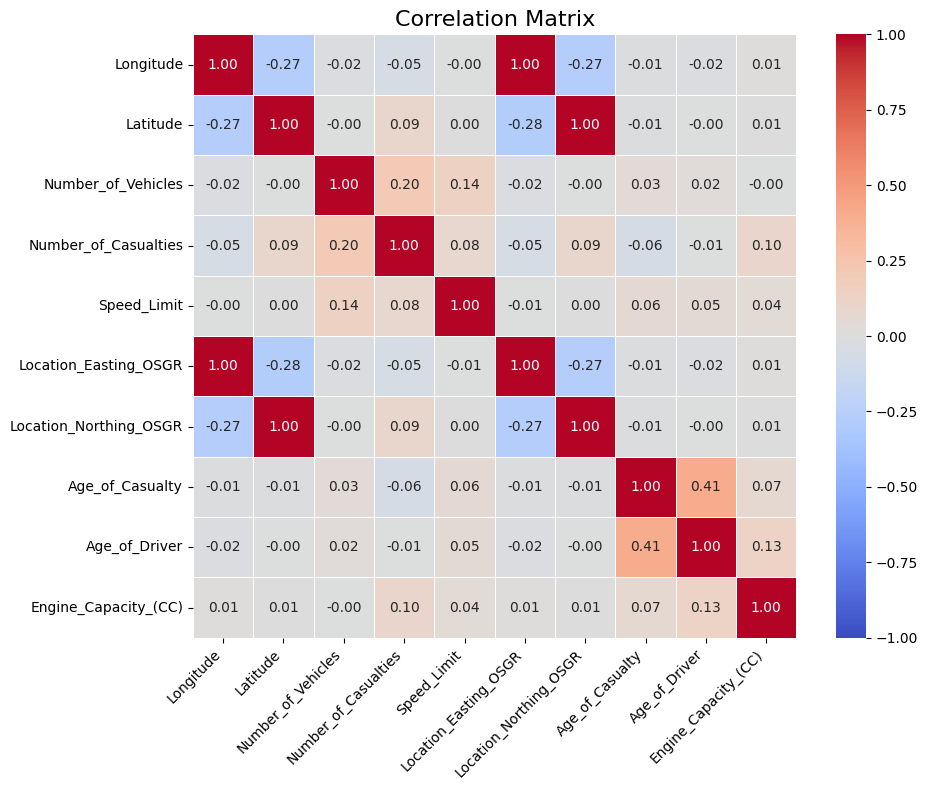

In [10]:
# 5. Calculate numerical statistics
# last error here
print("Numerical Statistics:")
stats, corr_matrix = calculate_numerical_stats(wo_onehot_df, numeric)

Creating histograms


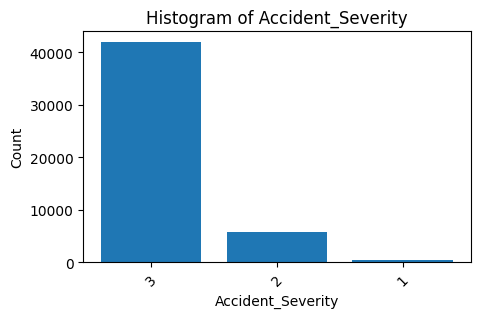

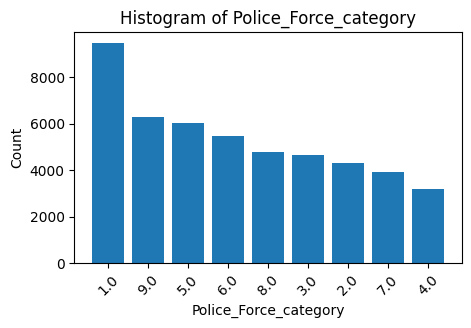

In [11]:
print("Creating histograms")
categorical_cols = [col for col in wo_onehot_df.columns 
                   if col.endswith("_category") or col in to_onehot]
create_histograms(wo_onehot_df, categorical_cols[:2])

# spark.stop()

# 3. Modelovanie - Vytvorenie popisných modelov (3b):

- Vytvorte k-means clustering model
- Pomocou vytvoreného modelu detekujte anomálie

In [30]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.classification import (
    DecisionTreeClassifier,
    LinearSVC,
    OneVsRest,
    NaiveBayes,
    RandomForestClassifier,
    GBTClassifier
)
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType
from pyspark.ml.linalg import Vectors
from pyspark import StorageLevel

In [31]:
feature_cols_onehot = [
    "Number_of_Vehicles",
    "Number_of_Casualties",
    "Speed_Limit",
    "Weather_Conditions_encoded",
    "Light_Conditions_encoded",
    "Road_Surface_Conditions_encoded",
    "Junction_Detail_encoded",
    "Road_Type_encoded",
    "Urban_or_Rural_Area_encoded",
    "Age_of_Driver"
]

feature_cols = [
    "Number_of_Vehicles",
    "Number_of_Casualties",
    "Speed_Limit",
    "Weather_Conditions",
    "Light_Conditions",
    "Road_Surface_Conditions",
    "Junction_Detail",
    "Road_Type",
    "Urban_or_Rural_Area",
    "Age_of_Driver"
]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
data = assembler.transform(wo_onehot_df).select("features", "Accident_Severity")

train, test = data.randomSplit([0.7, 0.3], seed=42)
train = train.repartition(20)
test = test.repartition(20)
print("Num of samples to be used for training: ", train.count());
print("Num of samples to be used for testing: ", test.count());

data.printSchema()
data.select("features").show(5, truncate=False)

Num of samples to be used for training:  33790
Num of samples to be used for testing:  14201
root
 |-- features: vector (nullable = true)
 |-- Accident_Severity: integer (nullable = true)

+-------------------------------------------+
|features                                   |
+-------------------------------------------+
|[5.0,3.0,30.0,1.0,4.0,1.0,6.0,6.0,1.0,38.0]|
|[5.0,3.0,30.0,1.0,4.0,1.0,6.0,6.0,1.0,51.0]|
|[5.0,3.0,30.0,1.0,4.0,1.0,6.0,6.0,1.0,38.0]|
|[1.0,1.0,30.0,1.0,4.0,2.0,6.0,6.0,1.0,53.0]|
|[2.0,1.0,30.0,1.0,1.0,1.0,6.0,6.0,1.0,32.0]|
+-------------------------------------------+
only showing top 5 rows



In [46]:
def fit_kmeans(k, evaluator, data_train, data_test):
    kmeans = KMeans(
        k=k,
        seed=42,
        featuresCol="features",
        predictionCol="cluster"
    )
    model = kmeans.fit(data_train)
    predictions = model.transform(data_test)
    score = evaluator.evaluate(predictions)
    print("Silhouette Score for k =", k, "is", score)
    return score, model

In [47]:
print("Running K-Means...")

evaluator = ClusteringEvaluator(
    predictionCol="cluster", 
    featuresCol="features",
    metricName="silhouette",  
    distanceMeasure="squaredEuclidean"
)

best_score = 0.
best_model = None
for i in range(3, 10):
    score, model = fit_kmeans(i, evaluator, train, test)
    if score > best_score or best_model == None:
        best_model = model
        best_score = score

Running K-Means...
Silhouette Score for k = 3 is 0.645107854902476
Silhouette Score for k = 4 is 0.6512065660022274
Silhouette Score for k = 5 is 0.6304146990835799
Silhouette Score for k = 6 is 0.5458230184660878
Silhouette Score for k = 7 is 0.5798914419173458
Silhouette Score for k = 8 is 0.5555452021071292
Silhouette Score for k = 9 is 0.5601662971491383


In [49]:
pred = best_model.transform(test)
centers = best_model.clusterCenters()

@udf(DoubleType())
def dist_to_centroid(v, cluster):
    return float(Vectors.squared_distance(v, Vectors.dense(centers[cluster])))

pred = pred.withColumn("distance", dist_to_centroid("features", "cluster"))

threshold = pred.approxQuantile("distance", [0.98], 0.)[0]
anomalies = pred.filter(pred.distance > threshold)

print(f"Anomaly threshold (98th pct): {threshold}")
print("Sample anomalies:")
anomalies.select("features", "cluster", "distance").show(5, truncate=False)

Anomaly threshold (98th pct): 573.0210892802212
Sample anomalies:
+-------------------------------------------+-------+------------------+
|features                                   |cluster|distance          |
+-------------------------------------------+-------+------------------+
|[2.0,2.0,40.0,1.0,1.0,1.0,3.0,6.0,2.0,89.0]|2      |1156.3830630239968|
|[2.0,2.0,30.0,1.0,1.0,1.0,1.0,6.0,1.0,81.0]|2      |627.7901250430099 |
|[4.0,2.0,30.0,3.0,4.0,4.0,3.0,6.0,2.0,80.0]|2      |590.1551771027654 |
|[1.0,3.0,30.0,1.0,1.0,1.0,3.0,6.0,1.0,83.0]|2      |726.250967052969  |
|[3.0,1.0,40.0,1.0,1.0,2.0,5.0,3.0,1.0,85.0]|2      |915.4728774196509 |
+-------------------------------------------+-------+------------------+
only showing top 5 rows



# 4/5. Modelovanie - Vytvorenie klasifikačných modelov typu (aspoň jeden model každého typu). + Vyhodnotenie (4b + 3b)

- Decision tree model
- Linear SVM
- Naive Bayes model
- Ensembles of decision trees (Random Forests, Gradient-boosted trees)

- Natrénovanie klasifikačného modelu na trénovacej množine a jeho evaluáciu na testovacej množine.
- Klasifikačný model vyhodnocujte použitím kontigenčnej tabuľky a vypočítaním metrík presnosti, návratnosti, F1 a MCC (Matthews Correlation Coefficient).

In [32]:
def count_classes(data):
    counts = data.groupBy("label").count().collect()
    counts_dict = {row["label"]: row["count"] for row in counts}
    return counts_dict

def undersample_class(data):
    from functools import reduce

    counts_dict = count_classes(data)
    min_count = min(counts_dict.values())
    
    undersampled_dfs = []
    for lbl, cnt in counts_dict.items():
        df_lbl = data.filter(col("label") == lbl)
        if cnt > min_count:
            fraction = min_count / cnt
            df_lbl = df_lbl.sample(False, fraction, seed=42)
        undersampled_dfs.append(df_lbl)
    
    data_under = reduce(DataFrame.unionAll, undersampled_dfs)    
    return data_under

In [ ]:
assembler = VectorAssembler(
    inputCols=feature_cols_onehot,
    outputCol="features"
)
data = assembler.transform(onehot_df) \
                .select("features", "Accident_Severity") \
                .withColumnRenamed("Accident_Severity", "label")
data_reduced = undersample_class(data)
data_reduced.groupBy("label").count().show()

# stratified split
labels = [r.label for r in data.select("label").distinct().collect()]
fractions = {l: 0.7 for l in labels}
train = data_reduced.stat.sampleBy("label", fractions, seed=42).repartition(20)
test = data_reduced.subtract(train).repartition(20)

print(f"Training rows: {train.count()}, Test rows: {test.count()}")

In [ ]:
def fit_and_eval(estimator, name):
    model = estimator.fit(train)
    preds = model.transform(test)

    evaler = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
    accuracy = evaler.setMetricName("accuracy").evaluate(preds)
    precision = evaler.setMetricName("weightedPrecision").evaluate(preds)
    recall = evaler.setMetricName("weightedRecall").evaluate(preds)
    f1 = evaler.setMetricName("f1").evaluate(preds)

    y_true = preds.select("label").rdd.flatMap(lambda x: x).collect()
    y_pred = preds.select("prediction").rdd.flatMap(lambda x: x).collect()

    from sklearn.metrics import matthews_corrcoef, confusion_matrix
    import matplotlib.pyplot as plt
    import numpy as np

    mcc = matthews_corrcoef(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    labels = sorted(set(y_true))

    # print metrics
    print(f"\n=== {name} ===")
    print(f"Accuracy  : {accuracy:.4f}")
    print(f"Precision : {precision:.4f}")
    print(f"Recall    : {recall:.4f}")
    print(f"F1‐score  : {f1:.4f}")
    print(f"MCC       : {mcc:.4f}")

    # plot conf matrix
    fig, ax = plt.subplots(figsize=(6,6))
    im = ax.imshow(cm, interpolation='nearest', aspect='auto')
    ax.figure.colorbar(im, ax=ax)
    ax.set(
        xticks=np.arange(len(labels)), 
        yticks=np.arange(len(labels)),
        xticklabels=labels, 
        yticklabels=labels,
        xlabel="Predicted label",
        ylabel="True label",
        title=f"Confusion Matrix: {name}"
    )
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j],
                    ha="center", va="center",
                    color="white" if cm[i,j] > thresh else "black")
    plt.show()

    return preds


=== Decision Tree ===
Accuracy  : 0.8167
Precision : 0.7522
Recall    : 0.8167
F1‐score  : 0.7352
MCC       : 0.0218


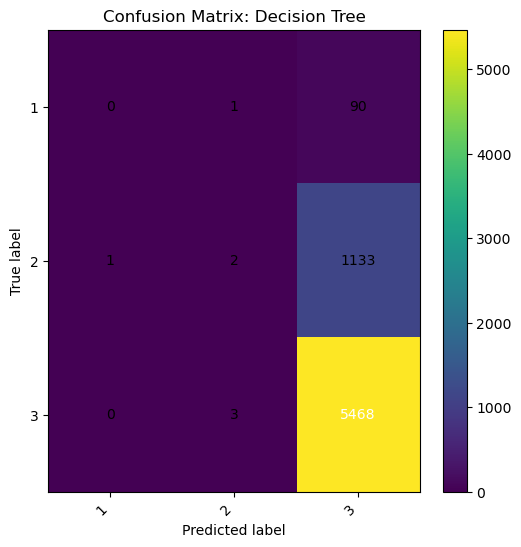

DataFrame[features: vector, label: int, rawPrediction: vector, probability: vector, prediction: double]

In [35]:
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features", seed=42)
fit_and_eval(dt, "Decision Tree")

In [ ]:
svm = LinearSVC(labelCol="label", featuresCol="features", maxIter=20)
ovr = OneVsRest(classifier=svm, labelCol="label", featuresCol="features")
fit_and_eval(ovr, "Linear SVM (One‐vs‐Rest)")

In [ ]:
nb = NaiveBayes(labelCol="label", featuresCol="features", modelType="multinomial")
fit_and_eval(nb, "Naive Bayes")

In [ ]:
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=100, seed=42)
fit_and_eval(rf, "Random Forest")

In [ ]:
gbt = GBTClassifier(labelCol="label", featuresCol="features", maxIter=50, seed=42)
fit_and_eval(gbt, "Gradient-Boosted Trees")